## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

https://github.com/skillcate/sentiment-analysis-with-deep-neural-networks/tree/main

## Setting the environment

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
pip install keras-preprocessing

In [ ]:
from keras_preprocessing.sequence import pad_sequences


## Loading dataset

In [ ]:
# Importing IMDb Movie Reviews dataset

url = 'https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/a1_IMDB_Dataset.csv'

movie_reviews = pd.read_csv(url)

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import pandas as pd

# Assuming you have a DataFrame named movie_reviews with 'review' and 'sentiment' columns

# Filter 500 records with positive sentiment
positive_reviews = movie_reviews[movie_reviews['sentiment'] == 'positive'].head(500)

# Filter 500 records with negative sentiment
negative_reviews = movie_reviews[movie_reviews['sentiment'] == 'negative'].head(500)

# Concatenate the two DataFrames vertically
merged_reviews = pd.concat([positive_reviews, negative_reviews])

# Shuffle the merged DataFrame
movie_reviews = merged_reviews.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(movie_reviews)


                                                review sentiment
0    DON'T TORTURE A DUCKLING is one of Fulci's ear...  positive
1    Do you ever wonder what is the worst movie eve...  negative
2    First, the CGI in this movie was horrible. I w...  negative
3    For a film made in Senegal, based, I guess loo...  negative
4    Just finished watching 2FTM. The trailers intr...  negative
..                                                 ...       ...
995  "ZZZZZZZZZZZZZZZZZZ"! If IMDb would allow one-...  negative
996  I love Jamie Foxx.<br /><br />And I enjoy 99% ...  negative
997  This movie is lame and not funny at all. The p...  negative
998  Only a very small child could overlook the abs...  negative
999  Adenoid Hynkel, a lowly soldier in World War O...  negative

[1000 rows x 2 columns]


In [ ]:

# Remove <br> tags from the review column
movie_reviews['review'] = movie_reviews['review'].str.replace('<br />', '')

# Display the DataFrame after removing <br> tags
print(movie_reviews.head())

                                              review sentiment
0  DON'T TORTURE A DUCKLING is one of Fulci's ear...  positive
1  Do you ever wonder what is the worst movie eve...  negative
2  First, the CGI in this movie was horrible. I w...  negative
3  For a film made in Senegal, based, I guess loo...  negative
4  Just finished watching 2FTM. The trailers intr...  negative


In [ ]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

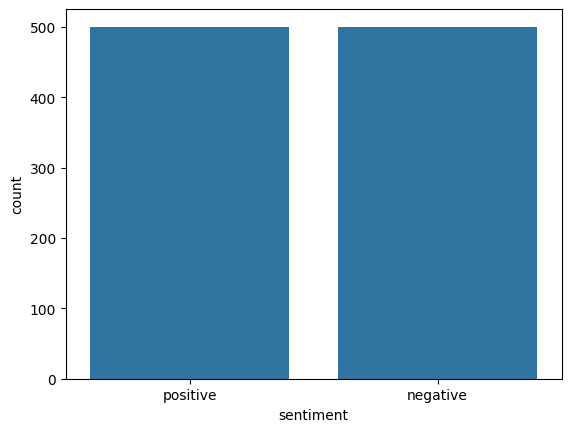

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [ ]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'First, the CGI in this movie was horrible. I watched it during a marathon of bad movies on the SciFi channel. At the end when the owner of the park gets killed, it\'s probably one of the worst examples of CGI I have even seen. Even Night of the Living Dead had better animation.That said, the movie had almost no plot. Why were they on that island in particular? Well, it wasn\'t stated in the movie. And, why would the people keep coming into the cat\'s area? Makes no sense.One thing that stood out in this movie was moderately good acting. In what could be called a "B made for TV movie" movie, the acting was very good. Parry Shen stood out in particular.If you have absolutely nothing to do on a Saturday, watch this movie. It may be good for some memorable quotes.'

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

# Define a function for text preprocessing
def preprocess_text(text):

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    # Tokenization
    words = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join tokens back into a string
    preprocessed_text = ' '.join(filtered_words)
    return preprocessed_text


In [ ]:
# Apply preprocessing function to each review in the 'review' column
X = [preprocess_text(review) for review in movie_reviews['review']]


In [ ]:
X[2]

'first cgi movie horrible watched marathon bad movie scifi channel end owner park get killed probably one worst example cgi even seen even night living dead better animation said movie almost plot island particular well stated movie would people keep coming cat area make sense one thing stood movie moderately good acting could called b made tv movie movie acting good parry shen stood particular absolutely nothing saturday watch movie may good memorable quote'

In [ ]:
# Converting sentiment labels to 0 & 1
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
y[:5]

array([1, 0, 0, 0, 0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

In [ ]:
X_train[2]

'basically family little boy jake think zombie closet parent fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parent divorcing arguing like real life jake closet totally ruin film expected see boogeyman similar movie instead watched drama meaningless thriller spot well playing parent descent dialog shot jake ignore'

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

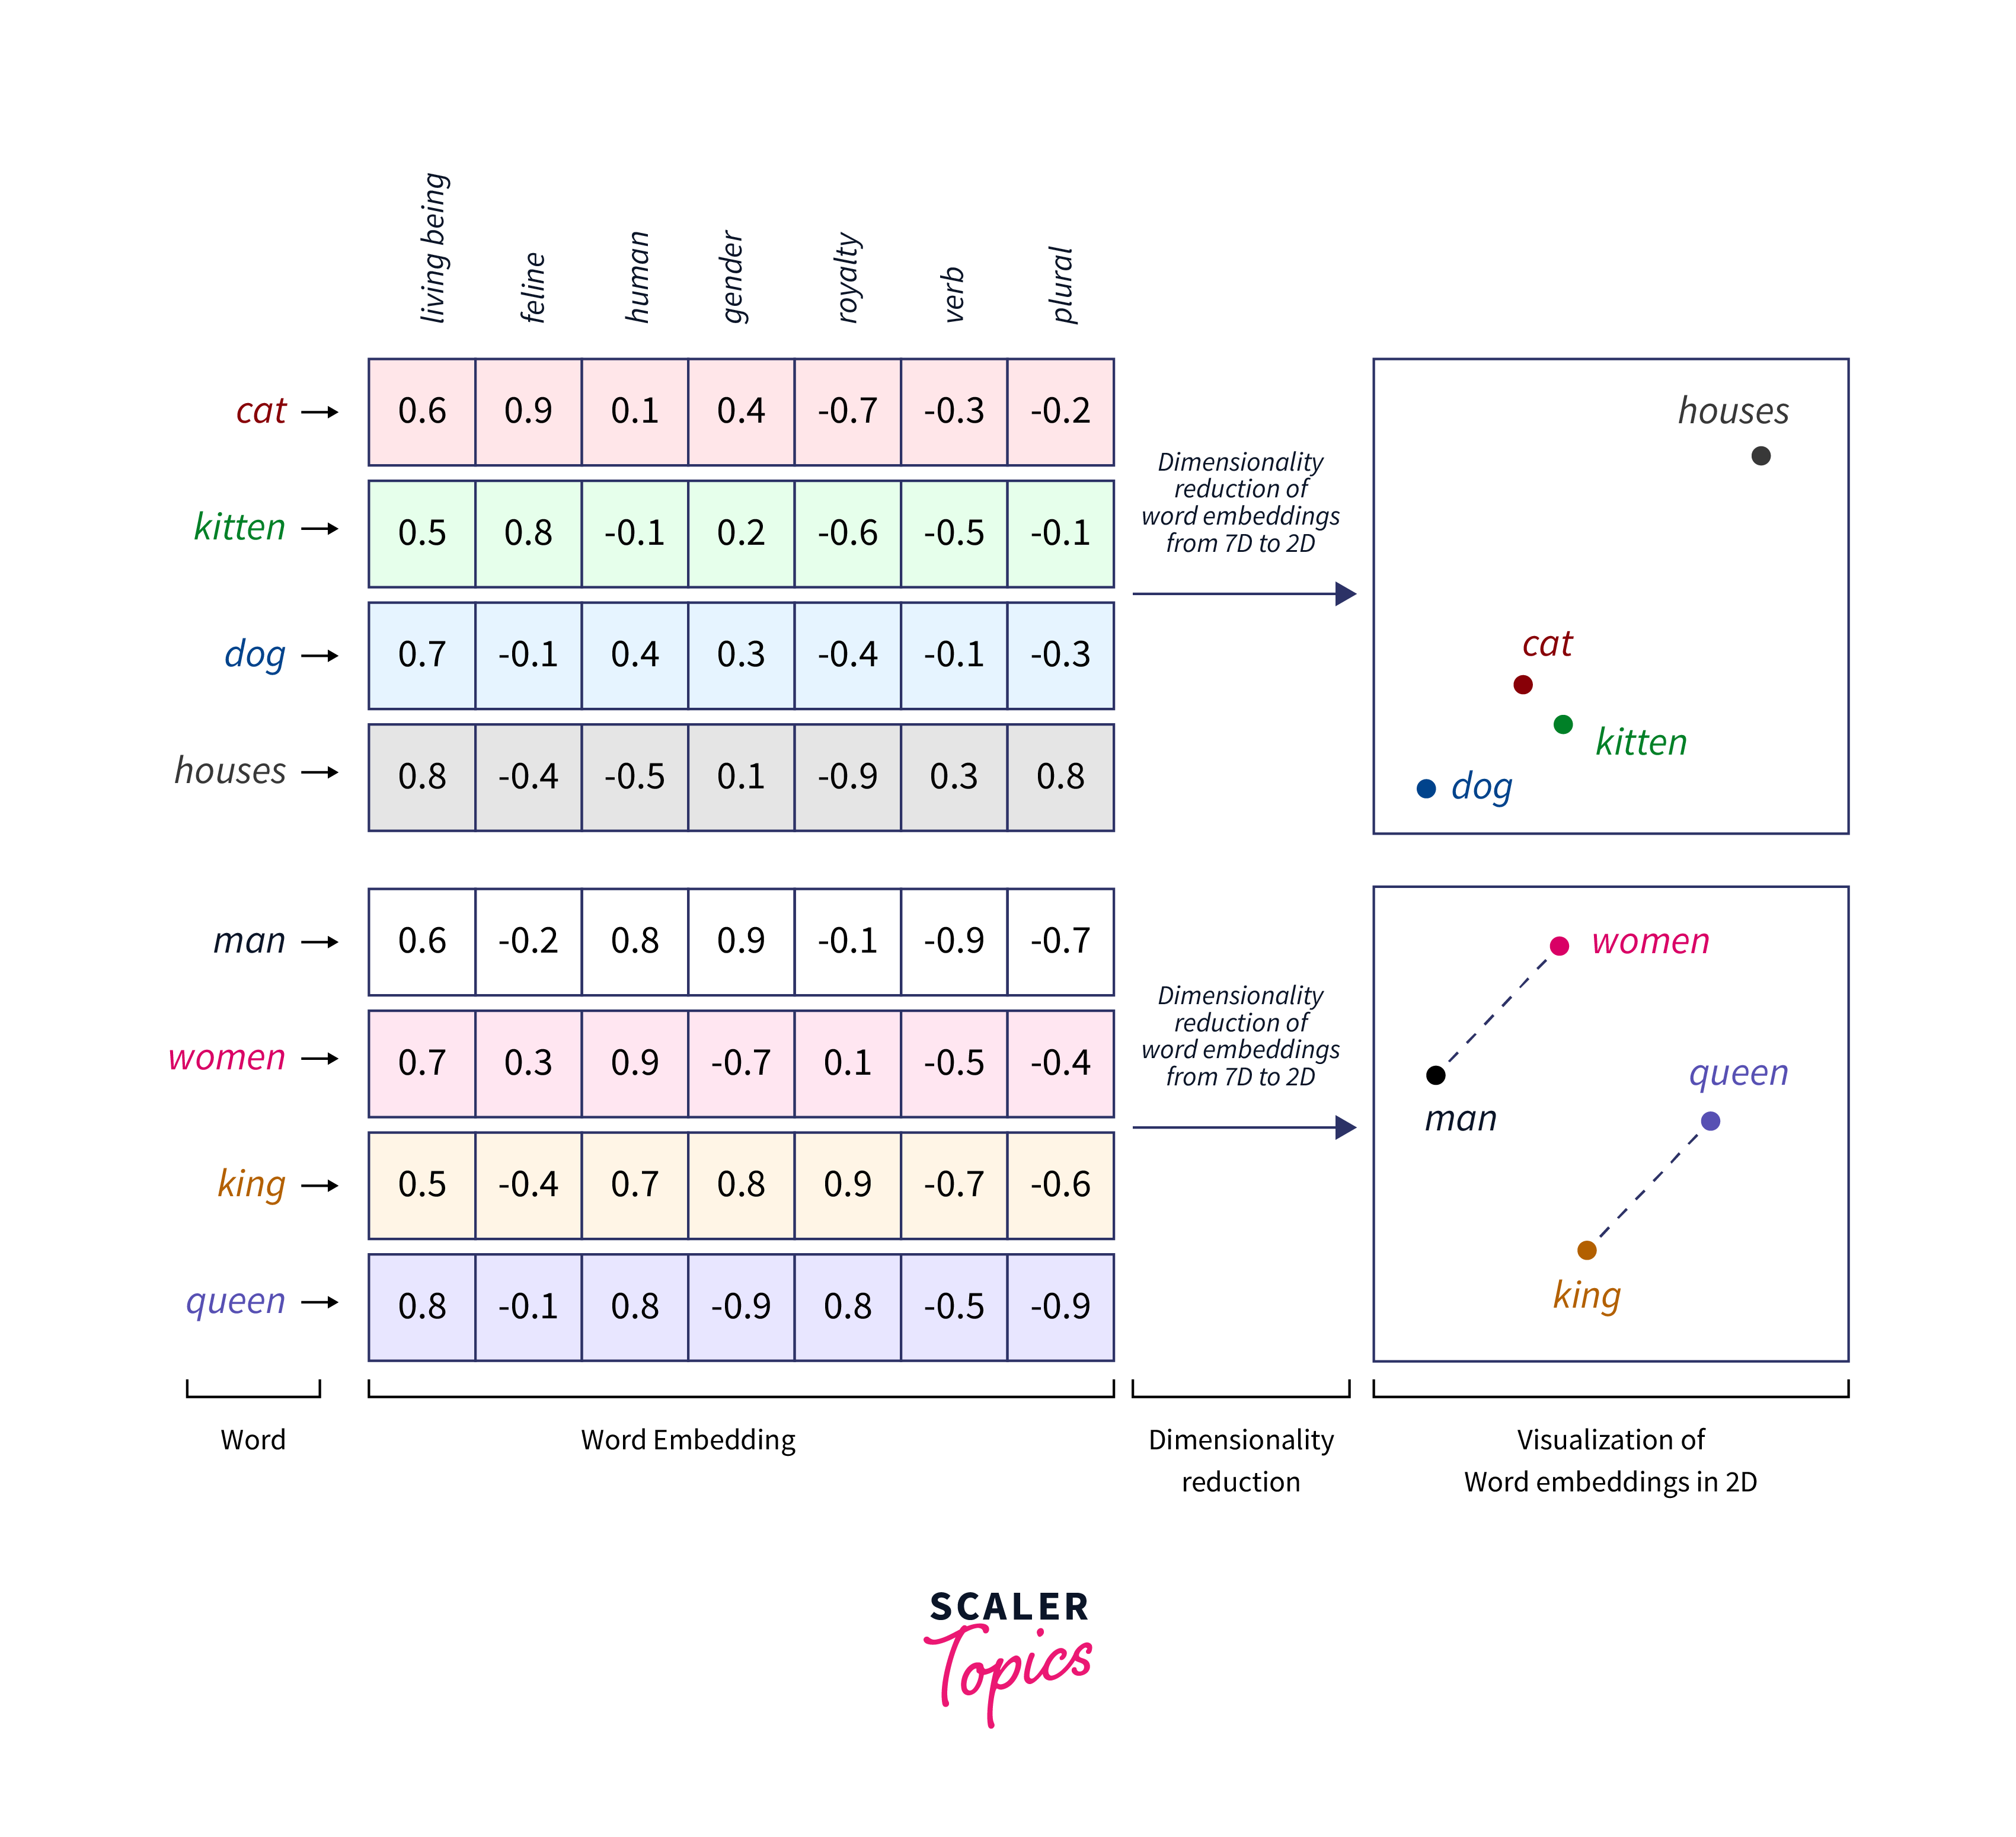

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[2]

[522,
 104,
 37,
 221,
 3228,
 26,
 384,
 3229,
 436,
 1044,
 5,
 1,
 3988,
 1847,
 1398,
 756,
 3228,
 696,
 342,
 3989,
 222,
 384,
 541,
 22,
 86,
 13,
 2,
 81,
 1045,
 464,
 280,
 280,
 1,
 1848,
 436,
 7444,
 7445,
 4,
 62,
 29,
 3228,
 3229,
 273,
 1648,
 2,
 830,
 7,
 7446,
 637,
 1,
 211,
 189,
 280,
 2767,
 464,
 1206,
 16,
 303,
 436,
 3990,
 513,
 122,
 3228,
 2107]

In [ ]:
import io
import json

In [ ]:
import requests

# URL of the tokenizer file
url = "https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/b3_tokenizer.json"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the content of the response (tokenizer JSON data)
    tokenizer_json = response.text

    # Save tokenizer JSON to a local file
    with open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
        f.write(tokenizer_json)
    print("Tokenizer JSON file saved successfully.")
else:
    print("Failed to fetch tokenizer JSON. Status code:", response.status_code)


Tokenizer JSON file saved successfully.


In [ ]:
# Saving dddd
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

The file b3_tokenizer.json likely contains the configuration and parameters of a tokenizer that has been trained or used in a natural language processing (NLP) task.
- Tokenizer Configuration
- Tokenizer Rules
- Tokenizer Vocabulary
- Tokenizer State etc.

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

14134

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words. These vectors capture semantic meaning based on the distributional properties of words in a large corpus of text. You can either train them on your own corpus or use pre-trained GloVe vectors that are available for download.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-04-01 19:48:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-01 19:48:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-01 19:48:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

b3_tokenizer.json  glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
#!cp /content/glove.6B.100d.txt /content/drive/MyDrive/glove.6B.100d.txt

In [87]:
#!ls -l /content/drive/MyDrive/*.txt

-rw------- 1 root root 613 Oct 17  2022 /content/drive/MyDrive/comedy.txt
-rw------- 1 root root 766 Aug 30  2022 /content/drive/MyDrive/renew-ssl.txt


In [86]:
#!rm /content/drive/MyDrive/glove.6B.100d.txt

In [89]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [90]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [114]:
embedding_matrix.shape

(14134, 100)

# Model Training with:

## Simple Neural Network

In [115]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [116]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1413400   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 1423401 (5.43 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 1413400 (5.39 MB)
_________________________________________________________________
None


In [117]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
5/5 [==============================] - 1s 62ms/step - loss: 0.7736 - acc: 0.4922 - val_loss: 0.7602 - val_acc: 0.4812
Epoch 2/6
5/5 [==============================] - 0s 14ms/step - loss: 0.5913 - acc: 0.6953 - val_loss: 0.7303 - val_acc: 0.5500
Epoch 3/6
5/5 [==============================] - 0s 15ms/step - loss: 0.4733 - acc: 0.8469 - val_loss: 0.6772 - val_acc: 0.6125
Epoch 4/6
5/5 [==============================] - 0s 17ms/step - loss: 0.3933 - acc: 0.9016 - val_loss: 0.6619 - val_acc: 0.6313
Epoch 5/6
5/5 [==============================] - 0s 17ms/step - loss: 0.3324 - acc: 0.9328 - val_loss: 0.6621 - val_acc: 0.6438
Epoch 6/6
5/5 [==============================] - 0s 16ms/step - loss: 0.2767 - acc: 0.9656 - val_loss: 0.6580 - val_acc: 0.6500


In [118]:
# # Model training

# snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [119]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

7/7 [==============================] - 0s 6ms/step - loss: 0.5794 - acc: 0.6650


In [120]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5793619155883789
Test Accuracy: 0.6650000214576721


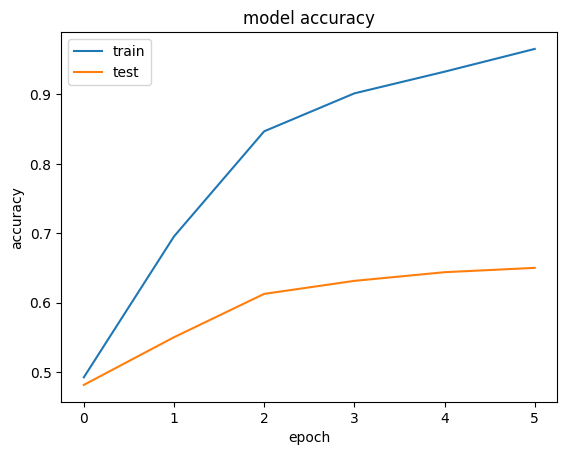

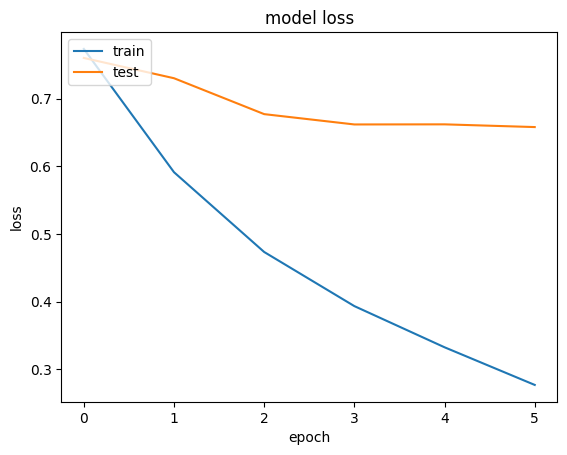

In [121]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [122]:
from keras.layers import Conv1D

In [123]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [124]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1413400   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1477657 (5.64 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 1413400 (5.39 MB)
_________________________________________________________________
None


In [125]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
5/5 [==============================] - 3s 142ms/step - loss: 0.8370 - acc: 0.5094 - val_loss: 0.7774 - val_acc: 0.5125
Epoch 2/6
5/5 [==============================] - 0s 92ms/step - loss: 0.6371 - acc: 0.6250 - val_loss: 0.7220 - val_acc: 0.5000
Epoch 3/6
5/5 [==============================] - 0s 92ms/step - loss: 0.5762 - acc: 0.6891 - val_loss: 0.6301 - val_acc: 0.6375
Epoch 4/6
5/5 [==============================] - 0s 93ms/step - loss: 0.5059 - acc: 0.7828 - val_loss: 0.6117 - val_acc: 0.6500
Epoch 5/6
5/5 [==============================] - 0s 93ms/step - loss: 0.4443 - acc: 0.9078 - val_loss: 0.6130 - val_acc: 0.6687
Epoch 6/6
5/5 [==============================] - 0s 95ms/step - loss: 0.3904 - acc: 0.9500 - val_loss: 0.5830 - val_acc: 0.7188


In [103]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

7/7 [==============================] - 0s 9ms/step - loss: 0.5715 - acc: 0.7250


In [126]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5793619155883789
Test Accuracy: 0.6650000214576721


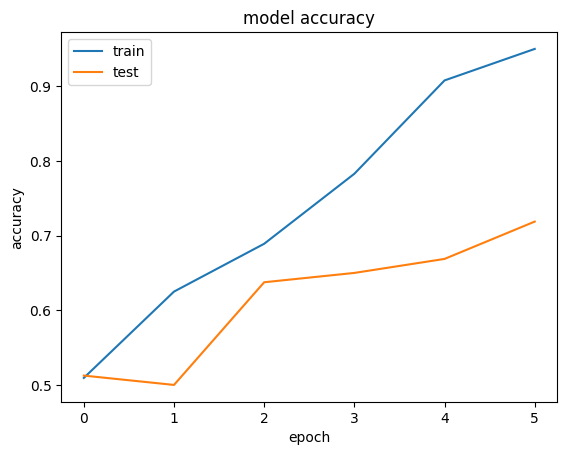

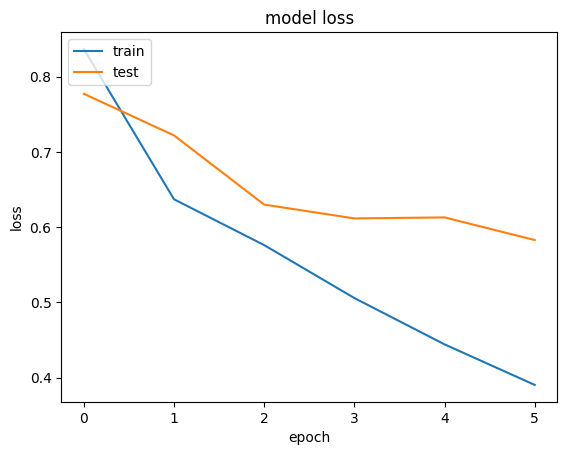

In [127]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [129]:
from keras.layers import LSTM

In [137]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [131]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1413400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1530777 (5.84 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 1413400 (5.39 MB)
_________________________________________________________________
None


In [132]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
5/5 [==============================] - 4s 433ms/step - loss: 0.6974 - acc: 0.5094 - val_loss: 0.6875 - val_acc: 0.5938
Epoch 2/6
5/5 [==============================] - 2s 472ms/step - loss: 0.6807 - acc: 0.5766 - val_loss: 0.6804 - val_acc: 0.5688
Epoch 3/6
5/5 [==============================] - 3s 587ms/step - loss: 0.6669 - acc: 0.5922 - val_loss: 0.6686 - val_acc: 0.5875
Epoch 4/6
5/5 [==============================] - 3s 599ms/step - loss: 0.6424 - acc: 0.6187 - val_loss: 0.6346 - val_acc: 0.6313
Epoch 5/6
5/5 [==============================] - 3s 628ms/step - loss: 0.5971 - acc: 0.6672 - val_loss: 0.6548 - val_acc: 0.6562
Epoch 6/6
5/5 [==============================] - 3s 685ms/step - loss: 0.5965 - acc: 0.6875 - val_loss: 0.6310 - val_acc: 0.6938


In [133]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

7/7 [==============================] - 0s 42ms/step - loss: 0.6639 - acc: 0.5950


In [134]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6639131307601929
Test Accuracy: 0.5950000286102295


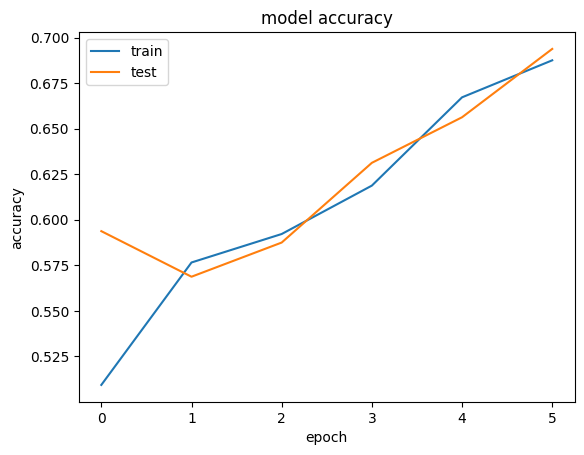

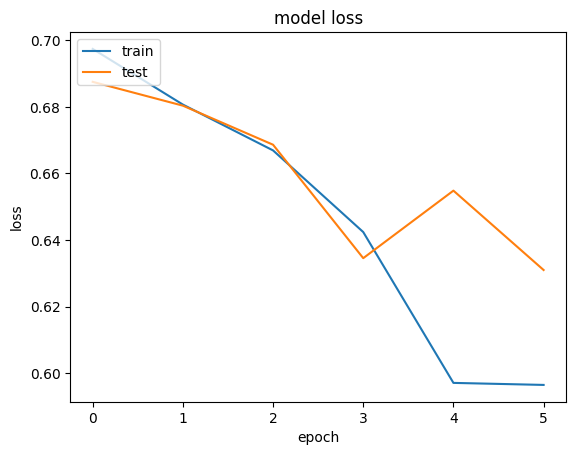

In [135]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [136]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [138]:
pwd # lists files in working directory

'/content'

In [140]:
import requests
from keras.models import load_model

# URL of the pre-trained model
model_url = "https://github.com/skillcate/sentiment-analysis-with-deep-neural-networks/raw/main/c1_lstm_model_acc_0.864.h5"

# Download the model file
response = requests.get(model_url)
model_file = "c1_lstm_model_acc_0.864.h5"

# Save the model file
with open(model_file, 'wb') as f:
    f.write(response.content)

# Load the model
pretrained_lstm_model = load_model(model_file)

# Summarize the model
pretrained_lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


In [141]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating
url2='https://raw.githubusercontent.com/skillcate/sentiment-analysis-with-deep-neural-networks/main/a2_IMDb_Unseen_Reviews.csv'
sample_reviews = pd.read_csv(url2)

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [145]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']
#unseen_reviews
unseen_processed =  [preprocess_text(review) for review in unseen_reviews]



In [147]:
unseen_processed[2]

'poor story reasonable otherwise realised alex garland would bothered watching remember reading book beach year ago thinking something nice time sure seen ex machina feeling story chosen simply appeal large audience rather manipulative unthinking unfeeling way normally write bad review anything preferring focus positive dislike felt write something put people wasting time assimilating nastiness case ex machina imagine garland wondering would next project googling ai quickly finding ai box experiment rather heart soul searching work would necessary produce anything original imagine quickly turning somebody else idea next big proposal present film studio unoriginal idea presented fairly pedestrian way lot image derived young person view sexuality made also wonder film rather prejudiced woman reasonably paced found yawning lot quite would expect good thriller domhnall gleeson ok pretty good job'

In [148]:
from keras_preprocessing.text import tokenizer_from_json

In [149]:
# Loading
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [150]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [152]:
unseen_tokenized[2]

[216,
 9,
 3439,
 760,
 5000,
 1850,
 5915,
 8,
 2324,
 54,
 269,
 748,
 161,
 2006,
 176,
 464,
 404,
 50,
 213,
 6,
 139,
 30,
 1040,
 14943,
 423,
 9,
 2163,
 217,
 1163,
 871,
 185,
 140,
 4927,
 23860,
 21803,
 23,
 1708,
 747,
 14,
 572,
 123,
 15304,
 971,
 992,
 2918,
 321,
 747,
 50,
 155,
 16,
 2970,
 6,
 40801,
 15273,
 290,
 1040,
 14943,
 679,
 5915,
 1357,
 8,
 246,
 974,
 87904,
 14035,
 774,
 1273,
 14035,
 714,
 2705,
 140,
 354,
 1116,
 2975,
 64,
 8,
 1570,
 2154,
 123,
 102,
 679,
 774,
 1433,
 1566,
 209,
 206,
 246,
 89,
 10042,
 826,
 2,
 988,
 4236,
 206,
 1207,
 841,
 6386,
 23,
 70,
 1256,
 7531,
 84,
 266,
 490,
 2787,
 20,
 18,
 440,
 2,
 140,
 14257,
 138,
 3490,
 1617,
 142,
 15331,
 70,
 78,
 8,
 387,
 5,
 556,
 22318,
 430,
 81,
 5,
 181]

In [153]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [154]:
unseen_padded[2]

array([  217,  1163,   871,   185,   140,  4927, 23860, 21803,    23,
        1708,   747,    14,   572,   123, 15304,   971,   992,  2918,
         321,   747,    50,   155,    16,  2970,     6, 40801, 15273,
         290,  1040, 14943,   679,  5915,  1357,     8,   246,   974,
       87904, 14035,   774,  1273, 14035,   714,  2705,   140,   354,
        1116,  2975,    64,     8,  1570,  2154,   123,   102,   679,
         774,  1433,  1566,   209,   206,   246,    89, 10042,   826,
           2,   988,  4236,   206,  1207,   841,  6386,    23,    70,
        1256,  7531,    84,   266,   490,  2787,    20,    18,   440,
           2,   140, 14257,   138,  3490,  1617,   142, 15331,    70,
          78,     8,   387,     5,   556, 22318,   430,    81,     5,
         181], dtype=int32)

In [155]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 878ms/step


array([[0.86242914],
       [0.9929711 ],
       [0.32016033],
       [0.17577358],
       [0.9745219 ],
       [0.0376893 ]], dtype=float32)

In [156]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.6
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,3.2
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,1.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.4


In [157]:
unseen_sentiments

array([[0.86242914],
       [0.9929711 ],
       [0.32016033],
       [0.17577358],
       [0.9745219 ],
       [0.0376893 ]], dtype=float32)

In [158]:
unseen_sentiments[0][0]

0.86242914

In [159]:
prediction_text= f"Positive Review with probable IMDb rating as: {np.round(unseen_sentiments[0][0]*10,1)}"

In [160]:
prediction_text

'Positive Review with probable IMDb rating as: 8.6'